# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip install numpy --upgrade

    100% |████████████████████████████████| 20.2MB 2.2MB/s eta 0:00:01
  Found existing installation: numpy 1.12.1
    Uninstalling numpy-1.12.1:
      Successfully uninstalled numpy-1.12.1


In [2]:
!pip -q install ./python

ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [3]:
from unityagents import UnityEnvironment
from dqn_agent import Agent
import torch
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [7]:
#Here we are taking random steps
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

### 4. Train your agent

A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

##### 4.1 Learning Algorithm - DQN
Deep Q-Networks(DQN) was proposed by Mnih et al. (2015). It takes agent's state as input and outputs Q action values.  It uses experience replay and target network to stabilize the model training. 


<figure>
    <img src="images/pseudocode-dqn.png" width="400" height="400">
    <br>
    <figcaption style = "text-align:center; font-style:italic">Taken from Human-level control through deep reinforcement learning(Mnih et al. (2015))</figcaption>
</figure>


##### 4.2 Model Architecture
The model is made of three fully connected layers. The number of neurons in first two layers is 64 and in the last layer it's equal to action size. Each layer's output except the last layer is transformed using the RelU activation function.  

##### 4.3 Hyperparameters
* BUFFER_SIZE = int(1e5)  # replay buffer size
* BATCH_SIZE = 64         # minibatch size
* GAMMA = 0.99            # discount factor
* TAU = 1e-3              # for soft update of target parameters
* LR = 5e-4               # learning rate 
* n_episodes = 2000       # maximum number of training episodes
* max_t = 1000            # maximum number of time steps per episode
* eps_start = 1.0         # starting value of epsilon, for epsilon-greedy action selection
* eps_end = 0.01          # minimum value of epsilon  
* eps_decay = 0.995       # multiplicative factor (per episode) for decreasing epsilon

In [8]:
agent = Agent(state_size=37, action_size=4, seed=0)

In [9]:


def dqn(n_episodes = 2000, max_t = 1000, eps_start = 1.0, eps_end = 0.01, eps_decay = 0.995):
    """Deep Q-Learning.
    Params
    ======
    n_episodes (int): maximum number of training episodes
    max_t (int): maximum number of time steps per episode
    eps_start (float): starting value of epsilon, for epsilon-greedy action selection
    eps_end (float) : minimum value of epsilon
    eps_decay (float) : multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                         #list containing scores from each episode
    scores_window = deque(maxlen = 100) # last 100 scores
    eps = eps_start                     #Initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)          # save most recent scores
        scores.append(score)                 # save most recent score
        eps = max(eps_end, eps_decay*eps)    # decrease epsilon
        print("\rEpisode {}\tAverage Score: {:.2f}".format(i_episode, np.mean(scores_window)), end ="")
        if i_episode % 100 == 0:
            print("\rEpisode {}\tAverage Score: {:.2f}".format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 13.0:
            print("\nEnvironment solved in {:d} episodes!\t Average score: {:.2f}".format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores
            

In [10]:
scores = dqn()

Episode 100	Average Score: 0.95
Episode 200	Average Score: 4.79
Episode 300	Average Score: 7.36
Episode 400	Average Score: 10.17
Episode 496	Average Score: 13.01
Environment solved in 496 episodes!	 Average score: 13.01


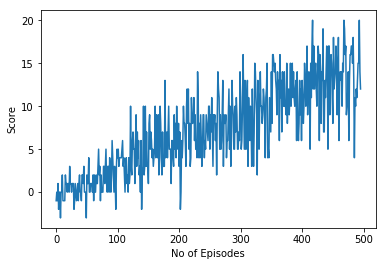

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel("Score")
plt.xlabel("No of Episodes")
plt.show()

In [12]:
#Load a trained agent
agent.qnetwork_local.load_state_dict(torch.load("checkpoint.pth"))

for i in range(3):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    score = 0
    for j in range(1000):
        action = agent.act(state)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break

    print("\rEpisode {}\t Score: {:.2f}".format(i+1, score))

            

Episode 1	 Score: 14.00
Episode 2	 Score: 14.00
Episode 3	 Score: 18.00


In [13]:
env.close()

### 5. Future ideas to improve the agent's performance

More experiments can be done to increase the performance of agent by applying different extensions of DQN:
* Double DQN (DDQN)
* Prioritized experience replay
* Dueling DQN
* A3C
* Distributional DQN
* Noisy DQN

We can also apply all the abobe extensions together. This was done by Deepmind's researchers and they have termed it Rainbow. This algorithm has outperformed each of the extension achieved SOTA results on Atari 2600.


<figure>
    <img src="images/rainbow.png" width="400" height="400">
    <br>
    <figcaption style = "text-align:center; font-style:italic">Taken from Rainbow: Combining Improvements in Deep Reinforcement Learning(Hessel et al. (2017))</figcaption>
</figure>